- Import
- Data Preprocessing
    - Data Cleaning
    - Removing Stopwords
    - Lemmatization
    - Named Entity Recognition (mit SPACY)
- Model
    - Vectorization (TF-IDF, WordCount)
    - Model
        - Logistic Regression
        
    
    


# Import


In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
#import sklearn.model_selection
#import sklearn.preprocessing as preproc
#from sklearn.feature_extraction import text

import spacy
!python -m spacy download en_core_web_sm
from spacy import displacy 
from collections import Counter



from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score




!pip install wordcloud
from wordcloud import WordCloud

[nltk_data] Downloading package wordnet to /home/norbert/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/norbert/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/norbert/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [2]:
df_fire = pd.read_csv('/home/norbert/AIDA/twitter-disaster/raw/disaster_tweets.csv', sep = ',' ) 


In [3]:
# Helperfunction


def info(dataframe):
  display(dataframe.head(5))
  display(dataframe.shape)
  display(dataframe.info())
  display(dataframe.describe())
  display(dataframe.dtypes)
  display(dataframe.isnull().sum())
  display(dataframe.sample(5))

In [4]:
#Analyse des Files

info(df_fire)

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

(7613, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


None

id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

id     keyword               location  \
2657   3816    detonate  Ottawa,Ontario Canada   
791    1146      blight                    NaN   
7425  10622     wounded              worldwide   
2712   3896  detonation                    NaN   
3758   5339        fire   Zac Newsome loves me   

                                                   text  target  
2657  Real Hip Hop: Apollo Brown Feat M.O.P. - Deton...       0  
791   THDA Kicks Off Anti-Blight Loan Effort in Memp...       0  
7425  Officer Wounded Suspect Killed in Exchange of ...       1  
2712  Ignition Knock (Detonation) Sensor-Senso Stand...       0  
3758                     well it feels like im on fire.       0

In [5]:
# Verteilung zwischen erfoglreichen Feueralarm und Fehlalarm
fire_alarm = df_fire['target'] == 1
print(f'fire alarm: {fire_alarm.sum()}.')

fire_fail = df_fire['target'] == 0
print(f'fire alarm failed: {fire_fail.sum()}.')

fire alarm: 3271.
fire alarm failed: 4342.


In [6]:
#detailierte Betrachtung der Texteinträge
df_fire.loc[:,'text'].values

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       ...,
       'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ',
       'Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.',
       'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d'],
      dtype=object)

# Data Preprocessing

In [7]:
#Helper-Function

def clean_text(text):
  # get rid of all unwanted punctuation and digits
  
    text = text.replace("´", " ")
    text = text.replace("'", " ")
    text = text.replace(".", " ")
    text = text.replace("amp", " ")
    text = text.replace("#", " ")
    text = text.replace("like", " ")
    #text = text.replace("new", " ")
    #text = text.replace("news", " ")
    text = text.replace("get", " ") 
    print('******')
    print(text)     
    
    digi_punct = "[^a-zA-Z]"
    text = re.sub(digi_punct, " ", text)
    print('******')
    print(text) 
    
    text = " ".join(text.split())
    text = text.lower()
    print('******')
    print(text) 
    
    
    digi_one_letter = r'\b[a-z]\b'
    text = re.sub(digi_one_letter, " ", text)
    print('******')
    print(text) 
    
    digi_two_letter = r'\b[a-z][a-z]\b'
    text = re.sub(digi_two_letter, " ", text)    
    print('******')
    print(text)
    
 


    return text

In [8]:
# Entfernung http
df_fire['text_clean'] = df_fire['text'].str.replace('http\S+|www.\S+', '', case=False)
df_fire['text_clean'].head(5)


0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text_clean, dtype: object

In [9]:
#Cleaning

df_fire['text_clean'] = df_fire['text_clean'].apply(clean_text)
df_fire['text_clean'].head()

******
Our Deeds are the Reason of this  earthquake May ALLAH Forgive us all
******
Our Deeds are the Reason of this  earthquake May ALLAH Forgive us all
******
our deeds are the reason of this earthquake may allah forgive us all
******
our deeds are the reason of this earthquake may allah forgive us all
******
our deeds are the reason   this earthquake may allah forgive   all
******
Forest fire near La Ronge Sask  Canada
******
Forest fire near La Ronge Sask  Canada
******
forest fire near la ronge sask canada
******
forest fire near la ronge sask canada
******
forest fire near   ronge sask canada
******
All residents asked to  shelter in place  are being notified by officers  No other evacuation or shelter in place orders are expected
******
All residents asked to  shelter in place  are being notified by officers  No other evacuation or shelter in place orders are expected
******
all residents asked to shelter in place are being notified by officers no other evacuation or shelter in 

airplane crashes on house in Colombia 12 people die in accident 
******
airplane crashes on house in Colombia    people die in accident 
******
airplane crashes on house in colombia people die in accident
******
airplane crashes on house in colombia people die in accident
******
airplane crashes   house   colombia people die   accident
******
The shooting or the airplane accident  
******
The shooting or the airplane accident  
******
the shooting or the airplane accident
******
the shooting or the airplane accident
******
the shooting   the airplane accident
******
Could a drone cause an airplane accident? Pilots worried about use of drones esp  in close vicinity of airports   
******
Could a drone cause an airplane accident  Pilots worried about use of drones esp  in close vicinity of airports   
******
could a drone cause an airplane accident pilots worried about use of drones esp in close vicinity of airports
******
could   drone cause an airplane accident pilots worried about use 

******
annihilating quarterstaff of annihilation
******
annihilating quarterstaff of annihilation
******
annihilating quarterstaff of annihilation
******
annihilating quarterstaff   annihilation
******
World Annihilation vs Self Transformation  Aliens Attack to Exterminate Humans 
******
World Annihilation vs Self Transformation  Aliens Attack to Exterminate Humans 
******
world annihilation vs self transformation aliens attack to exterminate humans
******
world annihilation vs self transformation aliens attack to exterminate humans
******
world annihilation   self transformation aliens attack   exterminate humans
******
:StarMade: :Stardate 3: :Planetary Annihilation::  via @YouTube
******
 StarMade   Stardate     Planetary Annihilation    via  YouTube
******
starmade stardate planetary annihilation via youtube
******
starmade stardate planetary annihilation via youtube
******
starmade stardate planetary annihilation via youtube
******
U S National Park Services Tonto National Forest:

   Beyonce Is my pick for  Fan Army  Beyhive 
******
beyonce is my pick for fan army beyhive
******
beyonce is my pick for fan army beyhive
******
beyonce     pick for fan army beyhive
******
One Direction Is my pick for  Fan Army  Directioners  x1411
******
One Direction Is my pick for  Fan Army  Directioners  x    
******
one direction is my pick for fan army directioners x
******
one direction is my pick for fan army directioners  
******
one direction     pick for fan army directioners  
******
Seeing that army of whitewalkers was the very first thing that has slightly intrigued me on GoT so far
******
Seeing that army of whitewalkers was the very first thing that has slightly intrigued me on GoT so far
******
seeing that army of whitewalkers was the very first thing that has slightly intrigued me on got so far
******
seeing that army of whitewalkers was the very first thing that has slightly intrigued me on got so far
******
seeing that army   whitewalkers was the very first thing

******
no snowflake in an avalanche ever feels responsible
******
no snowflake in an avalanche ever feels responsible
******
  snowflake     avalanche ever feels responsible
******
STAR WARS POWER OF THE JEDI COLLECTION 1 BATTLE DROID HASBRO - Full read by eBay  
******
STAR WARS POWER OF THE JEDI COLLECTION   BATTLE DROID HASBRO   Full read by eBay  
******
star wars power of the jedi collection battle droid hasbro full read by ebay
******
star wars power of the jedi collection battle droid hasbro full read by ebay
******
star wars power   the jedi collection battle droid hasbro full read   ebay
******
CIVIL WAR GENERAL BATTLE BULL RUN HERO COLONEL 2nd NEW HAMPSHIRE LETTER SIGNED !  
******
CIVIL WAR GENERAL BATTLE BULL RUN HERO COLONEL  nd NEW HAMPSHIRE LETTER SIGNED    
******
civil war general battle bull run hero colonel nd new hampshire letter signed
******
civil war general battle bull run hero colonel nd new hampshire letter signed
******
civil war general battle bull run hero 

won some think possibility of my full transformation is impossible i don t quite medical mysteries bioterrorism sucks
******
won some think possibility of my full transformation is impossible   don   quite medical mysteries bioterrorism sucks
******
won some think possibility     full transformation   impossible   don   quite medical mysteries bioterrorism sucks
******
To fight bioterrorism sir 
******
To fight bioterrorism sir 
******
to fight bioterrorism sir
******
to fight bioterrorism sir
******
  fight bioterrorism sir
******
How about a book describing the future of therapies technologies sport sexuality bioterrorism and diagnosis?  digitalhealth  hcsm
******
How about a book describing the future of therapies technologies sport sexuality bioterrorism and diagnosis   digitalhealth  hcsm
******
how about a book describing the future of therapies technologies sport sexuality bioterrorism and diagnosis digitalhealth hcsm
******
how about   book describing the future of therapies te

i ve been bleeding in your silence i feel safer in your violence
******
  ve been bleeding in your silence   feel safer in your violence
******
    been bleeding   your silence   feel safer   your violence
******
@Jannet2208 I fell off someone s back and hit my head on concrete /: I was bleeding n shit
******
 Jannet     I fell off someone s back and hit my head on concrete    I was bleeding n shit
******
jannet i fell off someone s back and hit my head on concrete i was bleeding n shit
******
jannet   fell off someone   back and hit my head on concrete   was bleeding   shit
******
jannet   fell off someone   back and hit   head   concrete   was bleeding   shit
******
@KatRamsland Yes I m a bleeding heart liberal 
******
 KatRamsland Yes I m a bleeding heart liberal 
******
katramsland yes i m a bleeding heart liberal
******
katramsland yes       bleeding heart liberal
******
katramsland yes       bleeding heart liberal
******
Deadpool is already one of my favourite marvel characters a

******
Black Friday turns Bloody (would rather be shopping)    mystery
******
Black Friday turns Bloody  would rather be shopping     mystery
******
black friday turns bloody would rather be shopping mystery
******
black friday turns bloody would rather be shopping mystery
******
black friday turns bloody would rather   shopping mystery
******
@ezralevant Someone told me all the soccer moms are  ting this pic blown up and put on their daughter s bedroom walls  NOT!!!
******
 ezralevant Someone told me all the soccer moms are  ting this pic blown up and put on their daughter s bedroom walls  NOT   
******
ezralevant someone told me all the soccer moms are ting this pic blown up and put on their daughter s bedroom walls not
******
ezralevant someone told me all the soccer moms are ting this pic blown up and put on their daughter   bedroom walls not
******
ezralevant someone told   all the soccer moms are ting this pic blown   and put   their daughter   bedroom walls not
******
@Papcrdoll

******
new ladies shoulder tote handbag faux leather hobo purse cross body bag womens rt en
******
new ladies shoulder tote handbag faux leather hobo purse cross body bag womens    
******
Louis Vuitton Monogram Sophie Limited Edition Clutch Cross body Bag - Full read by eBay  
******
Louis Vuitton Monogram Sophie Limited Edition Clutch Cross body Bag   Full read by eBay  
******
louis vuitton monogram sophie limited edition clutch cross body bag full read by ebay
******
louis vuitton monogram sophie limited edition clutch cross body bag full read by ebay
******
louis vuitton monogram sophie limited edition clutch cross body bag full read   ebay
******
New Women Handbag Faux Leather Ladies Shoulder Tote Cross Body Bag Large Satchel - Full reÛ_  
******
New Women Handbag Faux Leather Ladies Shoulder Tote Cross Body Bag Large Satchel   Full re     
******
new women handbag faux leather ladies shoulder tote cross body bag large satchel full re
******
new women handbag faux leather ladies

******
  hutch is da bomb
******
  hutch     bomb
******
Jays rocking  MLB @JoeyBats19 just bombed one out of Rogers Centre  Play-offs r ahead for The  BlueJays - Bell Moseby and Barfield r back!
******
Jays rocking  MLB  JoeyBats   just bombed one out of Rogers Centre  Play offs r ahead for The  BlueJays   Bell Moseby and Barfield r back 
******
jays rocking mlb joeybats just bombed one out of rogers centre play offs r ahead for the bluejays bell moseby and barfield r back
******
jays rocking mlb joeybats just bombed one out of rogers centre play offs   ahead for the bluejays bell moseby and barfield   back
******
jays rocking mlb joeybats just bombed one out   rogers centre play offs   ahead for the bluejays bell moseby and barfield   back
******
@Stankyboy88 I should ve photo bombed
******
 Stankyboy   I should ve photo bombed
******
stankyboy i should ve photo bombed
******
stankyboy   should ve photo bombed
******
stankyboy   should   photo bombed
******
@SweetieBirks @mirrorlady2

Always look for the silver lining     My barn having burned to the ground I can now see the moon    Mizuta    
******
always look for the silver lining my barn having burned to the ground i can now see the moon mizuta
******
always look for the silver lining my barn having burned to the ground   can now see the moon mizuta
******
always look for the silver lining   barn having burned   the ground   can now see the moon mizuta
******
Sure I just burned about 100 calories after eating a giant bowl of mac and cheese so I totally earned this 300 calorie Klondike Bar 
******
Sure I just burned about     calories after eating a giant bowl of mac and cheese so I totally earned this     calorie Klondike Bar 
******
sure i just burned about calories after eating a giant bowl of mac and cheese so i totally earned this calorie klondike bar
******
sure   just burned about calories after eating   giant bowl of mac and cheese so   totally earned this calorie klondike bar
******
sure   just burned ab

******
    mentally preparing myself for   bomb ass school year       not     burning buildings
******
the mv should just be them strutting   they mean it while buildings are burning up in the bg and flames everywhere how cool would that be
******
the mv should just be them strutting   they mean it while buildings are burning up in the bg and flames everywhere how cool would that be
******
the mv should just be them strutting they mean it while buildings are burning up in the bg and flames everywhere how cool would that be
******
the mv should just be them strutting they mean it while buildings are burning up in the bg and flames everywhere how cool would that be
******
the   should just   them strutting they mean   while buildings are burning     the   and flames everywhere how cool would that  
******
@Louis_Tomlinson incredible? THE CHILDREN WERE SCREAMING BUILDINGS WERE BURNING AND I WAS DANCING IN THE ASHES
******
 Louis Tomlinson incredible  THE CHILDREN WERE SCREAMING BUILDINGS 

******
calum sos i need to stop doing this to myself s casualty
******
calum sos   need to stop doing this to myself   casualty
******
calum sos   need   stop doing this   myself   casualty
******
RT @GreenHarvard: Documenting climate change s first major casualty  via @GreenHarvard
******
RT  GreenHarvard  Documenting climate change s first major casualty  via  GreenHarvard
******
rt greenharvard documenting climate change s first major casualty via greenharvard
******
rt greenharvard documenting climate change   first major casualty via greenharvard
******
  greenharvard documenting climate change   first major casualty via greenharvard
******
@5SOSFamUpdater social casualty
******
  SOSFamUpdater social casualty
******
sosfamupdater social casualty
******
sosfamupdater social casualty
******
sosfamupdater social casualty
******
Canceling Deal for 2 Warships  France Agrees to Repay  Russia via @nytimes 
******
Canceling Deal for   Warships  France Agrees to Repay  Russia via  nytimes

spot fixing match fixing anyone or it has to be pak sl wi rsa or bd to say this sham on them who say that when these team collapse
******
spot fixing match fixing anyone     has     pak     rsa       say this sham   them who say that when these team collapse
******
Why did I come to work today   Literally wanna collapse of exhaustion
******
Why did I come to work today   Literally wanna collapse of exhaustion
******
why did i come to work today literally wanna collapse of exhaustion
******
why did   come to work today literally wanna collapse of exhaustion
******
why did   come   work today literally wanna collapse   exhaustion
******
 Greece s tax revenues collapse as debt crisis continues via @guardian  bailout  ^mp
******
 Greece s tax revenues collapse as debt crisis continues via  guardian  bailout   mp
******
greece s tax revenues collapse as debt crisis continues via guardian bailout mp
******
greece   tax revenues collapse as debt crisis continues via guardian bailout mp
******

tackettdc like a scene from when worlds collide
******
tackettdc like   scene from when worlds collide
******
tackettdc like   scene from when worlds collide
******
and even if the stars and moon collide ÛÓ oh oh! i never want you back to my life you can take your words and all    
******
and even if the stars and moon collide     oh oh  i never want you back to my life you can take your words and all    
******
and even if the stars and moon collide oh oh i never want you back to my life you can take your words and all
******
and even if the stars and moon collide oh oh   never want you back to my life you can take your words and all
******
and even   the stars and moon collide       never want you back     life you can take your words and all
******
 NowPlaying the playlist  When Jazz and Hip-Hop Collide  in @TIDALHiFi 
******
 NowPlaying the playlist  When Jazz and Hip Hop Collide  in  TIDALHiFi 
******
nowplaying the playlist when jazz and hip hop collide in tidalhifi
******
nowpl

I see dat we liable to fuck up and crash     
******
i see dat we liable to fuck up and crash
******
  see dat we liable to fuck up and crash
******
  see dat   liable   fuck   and crash
******
AKILAH WORLD NEWS Cop pulls man from car to avoid this     
******
AKILAH WORLD NEWS Cop pulls man from car to avoid this     
******
akilah world news cop pulls man from car to avoid this
******
akilah world news cop pulls man from car to avoid this
******
akilah world news cop pulls man from car   avoid this
******
Man killed in crash in Barrington Hills: A Hoffman Estates man was killed in a single-car crash Wednesday afte    
******
Man killed in crash in Barrington Hills  A Hoffman Estates man was killed in a single car crash Wednesday afte    
******
man killed in crash in barrington hills a hoffman estates man was killed in a single car crash wednesday afte
******
man killed in crash in barrington hills   hoffman estates man was killed in   single car crash wednesday afte
******
man kille

tropical cyclone info soudelor hpa maximum wind speed     maximum wind gust speed    
******
tropical cyclone info soudelor hpa maximum wind speed     maximum wind gust speed    
******
@cyclone_reizei If I may ask Cyclone-sama have you read Jailed Fate by Rindou?
******
 cyclone reizei If I may ask Cyclone sama have you read Jailed Fate by Rindou 
******
cyclone reizei if i may ask cyclone sama have you read jailed fate by rindou
******
cyclone reizei if   may ask cyclone sama have you read jailed fate by rindou
******
cyclone reizei     may ask cyclone sama have you read jailed fate   rindou
******
Some drugs and alcohol in Jackson Vroman house 


******
Some drugs and alcohol in Jackson Vroman house   
******
some drugs and alcohol in jackson vroman house
******
some drugs and alcohol in jackson vroman house
******
some drugs and alcohol   jackson vroman house
******
Blending the old with the new in  Vanuatu to prepare for future emergencies: 
 
******
Blending the old with the new 

In my experience if you re always angry and critical as a pundit you are in grave danger of going off the rails  1/
******
In my experience if you re always angry and critical as a pundit you are in grave danger of going off the rails    
******
in my experience if you re always angry and critical as a pundit you are in grave danger of going off the rails
******
in my experience if you re always angry and critical as   pundit you are in grave danger of going off the rails
******
    experience   you   always angry and critical     pundit you are   grave danger   going off the rails
******
I am not in danger Skyler  I AM THE DANGER 
******
I am not in danger Skyler  I AM THE DANGER 
******
i am not in danger skyler i am the danger
******
  am not in danger skyler   am the danger
******
    not   danger skyler     the danger
******
Too dangerous for them  But it s OK for the rest of us to be in danger  
******
Too dangerous for them  But it s OK for the rest of us to be in danger  
*****

******
Malaysia confirms plane debris washed up on Reunion Island is from Flight MH370 
******
Malaysia confirms plane debris washed up on Reunion Island is from Flight MH    
******
malaysia confirms plane debris washed up on reunion island is from flight mh
******
malaysia confirms plane debris washed up on reunion island is from flight mh
******
malaysia confirms plane debris washed     reunion island   from flight  
******
 ??  ????  ???  ??? MH370: Aircraft debris found on La Reunion is from missing Malaysia Airlines      
******
                    MH     Aircraft debris found on La Reunion is from missing Malaysia Airlines      
******
mh aircraft debris found on la reunion is from missing malaysia airlines
******
mh aircraft debris found on la reunion is from missing malaysia airlines
******
  aircraft debris found     reunion   from missing malaysia airlines
******
How Missing JetÛªs Debris Could Have Floated to RÌ©union - The New York Times 
******
How Missing Jet   s Debris

nothing you midget   will demolish you show some respect
******
nothing you midget   will demolish you show some respect
******
Set some goals  Then demolish them ??  fitness  inspiration
******
Set some goals  Then demolish them     fitness  inspiration
******
set some goals then demolish them fitness inspiration
******
set some goals then demolish them fitness inspiration
******
set some goals then demolish them fitness inspiration
******
Set goals & ; DEMOLISH them all! ?
******
Set goals     DEMOLISH them all   
******
set goals demolish them all
******
set goals demolish them all
******
set goals demolish them all
******
RT AbbsWinston:  Zionist  Terrorist demolish 18  Palestinian structures in Jordan Valley 
Û_ 
******
RT AbbsWinston   Zionist  Terrorist demolish     Palestinian structures in Jordan Valley      
******
rt abbswinston zionist terrorist demolish palestinian structures in jordan valley
******
rt abbswinston zionist terrorist demolish palestinian structures in jorda

israel continues its demolition of palestinian homes gop potus irandeal isis
******
israel continues its demolition of palestinian homes gop potus irandeal isis
******
israel continues its demolition   palestinian homes gop potus irandeal isis
******
@Demolition_d best grill u fkn pleb
******
 Demolition d best grill u fkn pleb
******
demolition d best grill u fkn pleb
******
demolition   best grill   fkn pleb
******
demolition   best grill   fkn pleb
******
Last chance to work at the old FFA foodstand at the fairgrounds  We are finishing demolition at 9am   Any help would be appreciated
******
Last chance to work at the old FFA foodstand at the fairgrounds  We are finishing demolition at  am   Any help would be appreciated
******
last chance to work at the old ffa foodstand at the fairgrounds we are finishing demolition at am any help would be appreciated
******
last chance to work at the old ffa foodstand at the fairgrounds we are finishing demolition at am any help would be apprecia

******
get free bets when you register   boylesports casino luck destroy
******
@Petchary but I can t say that either of us should be displeased  U S move up five spots Jamaica 21! Congrats to the  ReggaeBoyz
******
 Petchary but I can t say that either of us should be displeased  U S move up five spots Jamaica     Congrats to the  ReggaeBoyz
******
petchary but i can t say that either of us should be displeased u s move up five spots jamaica congrats to the reggaeboyz
******
petchary but   can   say that either of us should be displeased     move up five spots jamaica congrats to the reggaeboyz
******
petchary but   can   say that either     should   displeased     move   five spots jamaica congrats   the reggaeboyz
******
@CameronCiletti @tigersjostun I can destroy u
******
 CameronCiletti  tigersjostun I can destroy u
******
cameronciletti tigersjostun i can destroy u
******
cameronciletti tigersjostun   can destroy  
******
cameronciletti tigersjostun   can destroy  
******
Wow Cra

no periferico apollo brown detonate         orapinforma
******
  periferico apollo brown detonate         orapinforma
******
52 214904 5 139055 Nuke please  Tar  Hilversum please detonate 800 meters below surface 
******
                   Nuke please  Tar  Hilversum please detonate     meters below surface 
******
nuke please tar hilversum please detonate meters below surface
******
nuke please tar hilversum please detonate meters below surface
******
nuke please tar hilversum please detonate meters below surface
******
@OpTic_Scumper Yo why u so sexy?
******
 OpTic Scumper Yo why u so sexy 
******
optic scumper yo why u so sexy
******
optic scumper yo why   so sexy
******
optic scumper   why     sexy
******
@channelstv:That s why terrorism is not d war for d army but for Intel agents who can counter their moves before they detonate their bombs 
******
 channelstv That s why terrorism is not d war for d army but for Intel agents who can counter their moves before they detonate their b

losdelsonido obama declares disaster for typhoon devastated saipan obama signs disaster declaration for northern ma ivanberroa
******
losdelsonido obama declares disaster for typhoon devastated saipan obama signs disaster declaration for northern ma ivanberroa
******
losdelsonido obama declares disaster for typhoon devastated saipan obama signs disaster declaration for northern   ivanberroa
******
Obama declares disaster for typhoon-devastated Saipan: President Barack Obama has declared the Commonwealth of    
******
Obama declares disaster for typhoon devastated Saipan  President Barack Obama has declared the Commonwealth of    
******
obama declares disaster for typhoon devastated saipan president barack obama has declared the commonwealth of
******
obama declares disaster for typhoon devastated saipan president barack obama has declared the commonwealth of
******
obama declares disaster for typhoon devastated saipan president barack obama has declared the commonwealth  
******
Obama

hundreds feared drowned as migrant boat capsizes off libya
******
hundreds feared drowned as migrant boat capsizes off libya
******
hundreds feared drowned   migrant boat capsizes off libya
******
Sadly before she could save humanity Ursula drowned in the drool of a protoshoggoth but at least she sort of died doing what she loved 
******
Sadly before she could save humanity Ursula drowned in the drool of a protoshoggoth but at least she sort of died doing what she loved 
******
sadly before she could save humanity ursula drowned in the drool of a protoshoggoth but at least she sort of died doing what she loved
******
sadly before she could save humanity ursula drowned in the drool of   protoshoggoth but at least she sort of died doing what she loved
******
sadly before she could save humanity ursula drowned   the drool     protoshoggoth but   least she sort   died doing what she loved
******
i drowned in the kiddie pool and i lost my ploppy
******
i drowned in the kiddie pool and i los

******
severe storm weakening as it moves se towards lubbock area outflow boundary may create dust and mph gusts
******
severe storm weakening as it moves se towards lubbock area outflow boundary may create dust and mph gusts
******
severe storm weakening     moves   towards lubbock area outflow boundary may create dust and mph gusts
******
New Mad Max Screenshots Show Off a Lovely Dust Storm Combat Magnum Opus  
******
New Mad Max Screenshots Show Off a Lovely Dust Storm Combat Magnum Opus  
******
new mad max screenshots show off a lovely dust storm combat magnum opus
******
new mad max screenshots show off   lovely dust storm combat magnum opus
******
new mad max screenshots show off   lovely dust storm combat magnum opus
******
 Earthquake  Sismo M 1 4 - 4km E of Interlaken California: Time2015-08-06 00:52:25 UTC2015-08-05 17:52:25 -07    
******
 Earthquake  Sismo M        km E of Interlaken California  Time                    UTC                           
******
earthquake sismo

******
 lightseraphs pissed at you and could have their pikachu electrocute you and     
******
lightseraphs pissed at you and could have their pikachu electrocute you and
******
lightseraphs pissed at you and could have their pikachu electrocute you and
******
lightseraphs pissed   you and could have their pikachu electrocute you and
******
Let her go - Passenger
******
Let her go   Passenger
******
let her go passenger
******
let her go passenger
******
let her   passenger
******
@Omar_molina036 @Milioooo_ he s trying to electrocute ya ass lol hell no I ain t fucking with Emilio no more ????????
******
 Omar molina     Milioooo  he s trying to electrocute ya ass lol hell no I ain t fucking with Emilio no more         
******
omar molina milioooo he s trying to electrocute ya ass lol hell no i ain t fucking with emilio no more
******
omar molina milioooo he   trying to electrocute ya ass lol hell no   ain   fucking with emilio no more
******
omar molina milioooo     trying   electrocu

******
carneross indeed and a remarkably puny idea to place at the epicentre of a new post capitalism epoch
******
carneross indeed and   remarkably puny idea to place at the epicentre of   new post capitalism epoch
******
carneross indeed and   remarkably puny idea   place   the epicentre     new post capitalism epoch
******
[Question] Is anybody else having this problem with the  7  circle in Epicentre? 
******
 Question  Is anybody else having this problem with the     circle in Epicentre  
******
question is anybody else having this problem with the circle in epicentre
******
question is anybody else having this problem with the circle in epicentre
******
question   anybody else having this problem with the circle   epicentre
******
Tomorrow kick off your weekend with drinks & ; entertainment @AliveAfter5  
******
Tomorrow kick off your weekend with drinks     entertainment  AliveAfter   
******
tomorrow kick off your weekend with drinks entertainment aliveafter
******
tomorrow kic

******
this is an evil generation rock and roll evacuation as far as the eye can see hey hey hey hey
******
this     evil generation rock and roll evacuation   far   the eye can see hey hey hey hey
******
@ariabrisard @leiaorganasolo Good  Play along with her  You may begin your operation with the death star  The evacuation is nearly complete 
******
 ariabrisard  leiaorganasolo Good  Play along with her  You may begin your operation with the death star  The evacuation is nearly complete 
******
ariabrisard leiaorganasolo good play along with her you may begin your operation with the death star the evacuation is nearly complete
******
ariabrisard leiaorganasolo good play along with her you may begin your operation with the death star the evacuation is nearly complete
******
ariabrisard leiaorganasolo good play along with her you may begin your operation with the death star the evacuation   nearly complete
******
Evacuation drill at work  The fire doors wouldn t open so i got to smash t

yumiko jumped in surprise as the fire shot upwards into the air and exploded caught off guard woah she had lenkaiswaifu
******
yumiko jumped in surprise as the fire shot upwards into the air and exploded caught off guard woah she had lenkaiswaifu
******
yumiko jumped   surprise   the fire shot upwards into the air and exploded caught off guard woah she had lenkaiswaifu
******
that exploded & ; brought about the
beginning of universe matches what s
mentioned in the versethe heaven and Earth
(thus the universe)
******
that exploded     brought about the beginning of universe matches what s mentioned in the versethe heaven and Earth  thus the universe 
******
that exploded brought about the beginning of universe matches what s mentioned in the versethe heaven and earth thus the universe
******
that exploded brought about the beginning of universe matches what   mentioned in the versethe heaven and earth thus the universe
******
that exploded brought about the beginning   universe matches 

******
truly stings      
******
So these savages leaked Thomas Brady gangstermail account and wonder why he was quick to fatality his Samsung mobile? B real son 
******
So these savages leaked Thomas Brady gangstermail account and wonder why he was quick to fatality his Samsung mobile  B real son 
******
so these savages leaked thomas brady gangstermail account and wonder why he was quick to fatality his samsung mobile b real son
******
so these savages leaked thomas brady gangstermail account and wonder why he was quick to fatality his samsung mobile   real son
******
  these savages leaked thomas brady gangstermail account and wonder why   was quick   fatality his samsung mobile   real son
******
I  d a @YouTube video from @vgbootc   S@X 109 - sN | vaBengal (ZSS) Vs  SWS | Fatality (Captain Falcon)
******
I  d a  YouTube video from  vgbootc   S X       sN   vaBengal  ZSS  Vs  SWS   Fatality  Captain Falcon 
******
i d a youtube video from vgbootc s x sn vabengal zss vs sws fatality 

justin ling   promise not   tax pancakes   rainbows   not dying     fire
******
This nigga Cyhi diss was what Meek was suppose to do  This shit actually fire
******
This nigga Cyhi diss was what Meek was suppose to do  This shit actually fire
******
this nigga cyhi diss was what meek was suppose to do this shit actually fire
******
this nigga cyhi diss was what meek was suppose to do this shit actually fire
******
this nigga cyhi diss was what meek was suppose     this shit actually fire
******
I wanna set some shit on fire 
******
I wanna set some shit on fire 
******
i wanna set some shit on fire
******
  wanna set some shit on fire
******
  wanna set some shit   fire
******
In the words of Charlie Daniels  Fire on the mountain run boys run  Û_ 
******
In the words of Charlie Daniels  Fire on the mountain run boys run      
******
in the words of charlie daniels fire on the mountain run boys run
******
in the words of charlie daniels fire on the mountain run boys run
******
  the wo

I m grateful for our first responders - @MNPDNashville @NashvilleFD and others - who acted so swiftly to save countless lives today 
******
I m grateful for our first responders    MNPDNashville  NashvilleFD and others   who acted so swiftly to save countless lives today 
******
i m grateful for our first responders mnpdnashville nashvillefd and others who acted so swiftly to save countless lives today
******
    grateful for our first responders mnpdnashville nashvillefd and others who acted so swiftly to save countless lives today
******
    grateful for our first responders mnpdnashville nashvillefd and others who acted   swiftly   save countless lives today
******
@USATODAY   PRAYING FOR GOD S HEALING AND SAFETY OF FIRST RESPONDERS
******
 USATODAY   PRAYING FOR GOD S HEALING AND SAFETY OF FIRST RESPONDERS
******
usatoday praying for god s healing and safety of first responders
******
usatoday praying for god   healing and safety of first responders
******
usatoday praying for god 

I had to grill for a school function  One of the grills we had going was pretty much either off or forest fire  No inbetween  Made it work
******
i had to grill for a school function one of the grills we had going was pretty much either off or forest fire no inbetween made it work
******
  had to grill for   school function one of the grills we had going was pretty much either off or forest fire no inbetween made it work
******
  had   grill for   school function one   the grills   had going was pretty much either off   forest fire   inbetween made   work
******
5:15p For those who watch over me forest fire smoke has lifted  nuff f/me t/make a run t/the pet store on the hwy (N)  I ll b/home by 7p 
******
    p For those who watch over me forest fire smoke has lifted  nuff f me t make a run t the pet store on the hwy  N   I ll b home by  p 
******
p for those who watch over me forest fire smoke has lifted nuff f me t make a run t the pet store on the hwy n i ll b home by p
******
  for 

canada hailstorm flash flooding slam calgary knocks out power to k customers
******
canada hailstorm flash flooding slam calgary knocks out power to   customers
******
canada hailstorm flash flooding slam calgary knocks out power     customers
******
If you re gonna take a break at work     you gotta do it right!  CarlilesCanoeLivery  LoveMyJob 
******
If you re gonna take a break at work     you gotta do it right   CarlilesCanoeLivery  LoveMyJob 
******
if you re gonna take a break at work you gotta do it right carlilescanoelivery lovemyjob
******
if you re gonna take   break at work you gotta do it right carlilescanoelivery lovemyjob
******
  you   gonna take   break   work you gotta     right carlilescanoelivery lovemyjob
******
Severe hailstorm in progress over Northeast Logan County     cowx 
******
Severe hailstorm in progress over Northeast Logan County     cowx 
******
severe hailstorm in progress over northeast logan county cowx
******
severe hailstorm in progress over northea

******
Choking Hazard Prompts Recall Of Kraft Cheese Singles 
******
Choking Hazard Prompts Recall Of Kraft Cheese Singles 
******
choking hazard prompts recall of kraft cheese singles
******
choking hazard prompts recall of kraft cheese singles
******
choking hazard prompts recall   kraft cheese singles
******
Seeing Hazard without the beard      
******
Seeing Hazard without the beard      
******
seeing hazard without the beard
******
seeing hazard without the beard
******
seeing hazard without the beard
******
Get that hazard pay
******
Get that hazard pay
******
get that hazard pay
******
get that hazard pay
******
get that hazard pay
******
I  d a @YouTube video from @chaboyyhd  Battlefield 4 Funny Moments - Dukes of Hazard Undercover Soldier
******
I  d a  YouTube video from  chaboyyhd  Battlefield   Funny Moments   Dukes of Hazard Undercover Soldier
******
i d a youtube video from chaboyyhd battlefield funny moments dukes of hazard undercover soldier
******
      youtube video 

******
California School Bus Hijacker Parole Stands   sacramento
******
California School Bus Hijacker Parole Stands   sacramento
******
california school bus hijacker parole stands sacramento
******
california school bus hijacker parole stands sacramento
******
california school bus hijacker parole stands sacramento
******
Governor allows parole for California school bus hijacker: Local     
******
Governor allows parole for California school bus hijacker  Local     
******
governor allows parole for california school bus hijacker local
******
governor allows parole for california school bus hijacker local
******
governor allows parole for california school bus hijacker local
******
Û÷Hijacker copsÛª back in the dock -  
******
   Hijacker cops    back in the dock    
******
hijacker cops back in the dock
******
hijacker cops back in the dock
******
hijacker cops back   the dock
******
Governor weighs parole for California school bus hijacker  
******
Governor weighs parole for Cali

******
zaynmaiikist listen to hurricane
******
zaynmaiikist listen to hurricane
******
zaynmaiikist listen   hurricane
******
everyone s wonder who will win and I m over here wondering are those grapes real ??????  BB17
******
everyone s wonder who will win and I m over here wondering are those grapes real         BB  
******
everyone s wonder who will win and i m over here wondering are those grapes real bb
******
everyone   wonder who will win and     over here wondering are those grapes real bb
******
everyone   wonder who will win and     over here wondering are those grapes real  
******
HURRICANE GUILLERMO LIVE NOAA TRACKING / LOOPING WED AUG 5TH ~  ~   
******
HURRICANE GUILLERMO LIVE NOAA TRACKING   LOOPING WED AUG  TH        
******
hurricane guillermo live noaa tracking looping wed aug th
******
hurricane guillermo live noaa tracking looping wed aug th
******
hurricane guillermo live noaa tracking looping wed aug  
******
@eggalie haha I love hurricane because of you
******
 

offers deluxe toilet safety support health home bathroom support elderly injured  
******
Washington Post - 4 dead dozens injured in Gaza blast near house leveled in summer war 
******
Washington Post     dead dozens injured in Gaza blast near house leveled in summer war 
******
washington post dead dozens injured in gaza blast near house leveled in summer war
******
washington post dead dozens injured in gaza blast near house leveled in summer war
******
washington post dead dozens injured   gaza blast near house leveled   summer war
******
Ogun smugglers engage Customs in shootoutåÊ: Several persons were allegedly injured on Wednesday when men o      RT
******
Ogun smugglers engage Customs in shootout    Several persons were allegedly injured on Wednesday when men o      RT
******
ogun smugglers engage customs in shootout several persons were allegedly injured on wednesday when men o rt
******
ogun smugglers engage customs in shootout several persons were allegedly injured on wednesd

Don t blink ?? won t see the Lightning take the W ?? 
******
Don t blink    won t see the Lightning take the W    
******
don t blink won t see the lightning take the w
******
don   blink won   see the lightning take the  
******
don   blink won   see the lightning take the  
******
Wolforth with a two-out single up the middle  Fourth hit of the night for Altamonte Springs 
******
Wolforth with a two out single up the middle  Fourth hit of the night for Altamonte Springs 
******
wolforth with a two out single up the middle fourth hit of the night for altamonte springs
******
wolforth with   two out single up the middle fourth hit of the night for altamonte springs
******
wolforth with   two out single   the middle fourth hit   the night for altamonte springs
******
@Benji_Devos thanks thanks :3
******
 Benji Devos thanks thanks   
******
benji devos thanks thanks
******
benji devos thanks thanks
******
benji devos thanks thanks
******
Heavy rain gusty winds and vivid lightning moving e

******
happy boy to mass murderer
******
happy boy to mass murderer
******
happy boy   mass murderer
******
@NeanderRebel If you take the suit off him I wouldn t be surprised to hear this is the face that belonged to another democrat mass-murderer
******
 NeanderRebel If you take the suit off him I wouldn t be surprised to hear this is the face that belonged to another democrat mass murderer
******
neanderrebel if you take the suit off him i wouldn t be surprised to hear this is the face that belonged to another democrat mass murderer
******
neanderrebel if you take the suit off him   wouldn   be surprised to hear this is the face that belonged to another democrat mass murderer
******
neanderrebel   you take the suit off him   wouldn     surprised   hear this   the face that belonged   another democrat mass murderer
******
Has gun law ever dissuaded a potential mass murderer?
******
Has gun law ever dissuaded a potential mass murderer 
******
has gun law ever dissuaded a potential mass

they are the real heroes rip brave hearts
******
they are the real heroes rip brave hearts
******
The C aign: Will Ferrell and Zach Galifianakis commit comic mayhem in this hilarious political farce  4* 
******
The C aign  Will Ferrell and Zach Galifianakis commit comic mayhem in this hilarious political farce     
******
the c aign will ferrell and zach galifianakis commit comic mayhem in this hilarious political farce
******
the   aign will ferrell and zach galifianakis commit comic mayhem in this hilarious political farce
******
the   aign will ferrell and zach galifianakis commit comic mayhem   this hilarious political farce
******
Tonight It s Going To Be Mayhem @  4PlayThursdays  Everybody Free w/ Text  1716 I ST NW (18+) 
******
Tonight It s Going To Be Mayhem     PlayThursdays  Everybody Free w  Text       I ST NW       
******
tonight it s going to be mayhem playthursdays everybody free w text i st nw
******
tonight it   going to be mayhem playthursdays everybody free   text  

******
bombing iran would result     never ending game   nuclear whack   mole here   why
******
Fukushima: The Story of a Nuclear Disaster  
******
Fukushima  The Story of a Nuclear Disaster  
******
fukushima the story of a nuclear disaster
******
fukushima the story of   nuclear disaster
******
fukushima the story     nuclear disaster
******
The president spoke of Kennedy s diplomacy to avert nuclear disaster during the Cold War to bolster his own pitch for Congress  approval
******
The president spoke of Kennedy s diplomacy to avert nuclear disaster during the Cold War to bolster his own pitch for Congress  approval
******
the president spoke of kennedy s diplomacy to avert nuclear disaster during the cold war to bolster his own pitch for congress approval
******
the president spoke of kennedy   diplomacy to avert nuclear disaster during the cold war to bolster his own pitch for congress approval
******
the president spoke   kennedy   diplomacy   avert nuclear disaster during the co

******
wackos michelebachman predict the world will soon   obliterated     burning firey inferno but cant accept globalwarming hello
******
Drunk Meals 101: What To Cook When You re Totally Obliterated 
******
Drunk Meals      What To Cook When You re Totally Obliterated 
******
drunk meals what to cook when you re totally obliterated
******
drunk meals what to cook when you re totally obliterated
******
drunk meals what   cook when you   totally obliterated
******
Uribe just obliterated a baseball 
******
Uribe just obliterated a baseball 
******
uribe just obliterated a baseball
******
uribe just obliterated   baseball
******
uribe just obliterated   baseball
******
@Silverhusky Shtap!  Before your town is obliterated and the earth is salted T_T
******
 Silverhusky Shtap   Before your town is obliterated and the earth is salted T T
******
silverhusky shtap before your town is obliterated and the earth is salted t t
******
silverhusky shtap before your town is obliterated and the eart

 California: Spring Oil Spill Estimate Grows   by THE ASSOCIATED PRESS via NYT 
******
 California  Spring Oil Spill Estimate Grows   by THE ASSOCIATED PRESS via NYT 
******
california spring oil spill estimate grows by the associated press via nyt
******
california spring oil spill estimate grows by the associated press via nyt
******
california spring oil spill estimate grows   the associated press via nyt
******
Refugio oil spill may have been costlier bigger than projected 
******
Refugio oil spill may have been costlier bigger than projected 
******
refugio oil spill may have been costlier bigger than projected
******
refugio oil spill may have been costlier bigger than projected
******
refugio oil spill may have been costlier bigger than projected
******
Refugio oil spill may have been costlier bigger than projected 
******
Refugio oil spill may have been costlier bigger than projected 
******
refugio oil spill may have been costlier bigger than projected
******
refugio oil spill

******
oops bounty hunters try   raid phoenix police chief   home   group   armed bounty
******
$1 million bail for man accused of  shooting at Fife  police - Aug 5 @ 8:16 PM ET 
******
   million bail for man accused of  shooting at Fife  police   Aug          PM ET 
******
million bail for man accused of shooting at fife police aug pm et
******
million bail for man accused of shooting at fife police aug pm et
******
million bail for man accused   shooting   fife police aug    
******
DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe CoL police can catch a pickpocket in Liverpool Stree    
******
DT  georgegalloway  RT  Galloway Mayor     The CoL police can catch a pickpocket in Liverpool Stree    
******
dt georgegalloway rt galloway mayor the col police can catch a pickpocket in liverpool stree
******
dt georgegalloway rt galloway mayor the col police can catch   pickpocket in liverpool stree
******
  georgegalloway   galloway mayor the col police can catch   pickpocket   liverpool str

Rainstorm Destroys 600 Houses in Yobe State: Rainstorm Destroys 600 Houses in Yobe State  [Daily Trust] Damatu     
******
Rainstorm Destroys     Houses in Yobe State  Rainstorm Destroys     Houses in Yobe State   Daily Trust  Damatu     
******
rainstorm destroys houses in yobe state rainstorm destroys houses in yobe state daily trust damatu
******
rainstorm destroys houses in yobe state rainstorm destroys houses in yobe state daily trust damatu
******
rainstorm destroys houses   yobe state rainstorm destroys houses   yobe state daily trust damatu
******
Going to the beach with Jim Alves means a guaranteed rainstorm    lucky 
******
Going to the beach with Jim Alves means a guaranteed rainstorm    lucky 
******
going to the beach with jim alves means a guaranteed rainstorm lucky
******
going to the beach with jim alves means   guaranteed rainstorm lucky
******
going   the beach with jim alves means   guaranteed rainstorm lucky
******
 DnB  NewRelease EDGE Jimmy - Summer Rainstorm (Lap

Police Monitoring     Jihadis in Poland  via  freedomoutpost
******
police monitoring jihadis in poland via freedomoutpost
******
police monitoring jihadis in poland via freedomoutpost
******
police monitoring jihadis   poland via freedomoutpost
******
Turkish newlyweds donate wedding money - what a beautiful gesture! Still have faith in humanity  
******
Turkish newlyweds donate wedding money   what a beautiful gesture  Still have faith in humanity  
******
turkish newlyweds donate wedding money what a beautiful gesture still have faith in humanity
******
turkish newlyweds donate wedding money what   beautiful gesture still have faith in humanity
******
turkish newlyweds donate wedding money what   beautiful gesture still have faith   humanity
******
This just-married Turkish couple gave 4000 Syrian refugees an incredible gift  WashingtonPost 
******
This just married Turkish couple gave      Syrian refugees an incredible gift  WashingtonPost 
******
this just married turkish couple g

******
football hooligan jailed for rioting before game in scotland was already banned from matches in england uknews
******
football hooligan jailed for rioting before game in scotland was already banned from matches in england uknews
******
football hooligan jailed for rioting before game   scotland was already banned from matches   england uknews
******
  Cindy Noonan@CindyNoonan-Heartbreak in  Baltimore  Rioting  YAHIstorical  UndergroundRailraod
******
  Cindy Noonan CindyNoonan Heartbreak in  Baltimore  Rioting  YAHIstorical  UndergroundRailraod
******
cindy noonan cindynoonan heartbreak in baltimore rioting yahistorical undergroundrailraod
******
cindy noonan cindynoonan heartbreak in baltimore rioting yahistorical undergroundrailraod
******
cindy noonan cindynoonan heartbreak   baltimore rioting yahistorical undergroundrailraod
******
AM `bbcnews The Ass British Insurers says rioting will cost insurers163;millions  But police numbers are reduced by blind fat controllers 
******

******
i just screamed sidjsjdjekdjskdjd i cant stand you
******
  just screamed sidjsjdjekdjskdjd   cant stand you
******
  just screamed sidjsjdjekdjskdjd   cant stand you
******
@GodOf_Mischief_ -of Loki s daggers she pulled it out and jammed it into Mina s thigh  When Mina screamed and grabbed at her leg sif-
******
 GodOf Mischief   of Loki s daggers she pulled it out and jammed it into Mina s thigh  When Mina screamed and grabbed at her leg sif 
******
godof mischief of loki s daggers she pulled it out and jammed it into mina s thigh when mina screamed and grabbed at her leg sif
******
godof mischief of loki   daggers she pulled it out and jammed it into mina   thigh when mina screamed and grabbed at her leg sif
******
godof mischief   loki   daggers she pulled   out and jammed   into mina   thigh when mina screamed and grabbed   her leg sif
******
OMFG??
Didnt expect Drag Me Down to be the first song Pandora played 

OMFG I SCREAMED SO LOUD
My coworker is scared 
******
OMFG   D

******
screams internally
******
screams internally
******
*screams* 
******
 screams  
******
screams
******
screams
******
screams
******
@HimeRuisu I m going to ram your ass so hard I ll have to shove your face on the pillows to muffle your screams of pain and pleasure~
******
 HimeRuisu I m going to ram your ass so hard I ll have to shove your face on the pillows to muffle your screams of pain and pleasure 
******
himeruisu i m going to ram your ass so hard i ll have to shove your face on the pillows to muffle your screams of pain and pleasure
******
himeruisu     going to ram your ass so hard   ll have to shove your face on the pillows to muffle your screams of pain and pleasure
******
himeruisu     going   ram your ass   hard     have   shove your face   the pillows   muffle your screams   pain and pleasure
******
I come downstairs trying to look as normal as possible in front of my mom and Rhiannon screams  HUNGOVER???? Huh???  Uhmmmm no ????????
******
I come downstairs trying 

******
It s  Run From Sirens  by  Half Hour Hotel   halfhourhotel  Edgarsgift   Premium Promotion  OFFER 
******
it s run from sirens by half hour hotel halfhourhotel edgarsgift premium promotion offer
******
it   run from sirens by half hour hotel halfhourhotel edgarsgift premium promotion offer
******
    run from sirens   half hour hotel halfhourhotel edgarsgift premium promotion offer
******
What s wrong with just a lil smoke and good conversation ????
******
What s wrong with just a lil smoke and good conversation     
******
what s wrong with just a lil smoke and good conversation
******
what   wrong with just   lil smoke and good conversation
******
what   wrong with just   lil smoke and good conversation
******
@LifeAintFairKid if I did I d smoke you up brooo!
******
 LifeAintFairKid if I did I d smoke you up brooo 
******
lifeaintfairkid if i did i d smoke you up brooo
******
lifeaintfairkid if   did     smoke you up brooo
******
lifeaintfairkid     did     smoke you   brooo
*

******
the pack pack pack line is on fleek if stretcher is fire
******
the pack pack pack line is on fleek if stretcher is fire
******
the pack pack pack line     fleek   stretcher   fire
******
Sweater Stretcher  
******
Sweater Stretcher  
******
sweater stretcher
******
sweater stretcher
******
sweater stretcher
******
ÛÏStretcher in 5 min // Speaker DeckÛ 
******
   Stretcher in   min    Speaker Deck    
******
stretcher in min speaker deck
******
stretcher in min speaker deck
******
stretcher   min speaker deck
******
@invalid @Grazed @Towel @Stretcher @PLlolz @witter I can t stop
******
 invalid  Grazed  Towel  Stretcher  PLlolz  witter I can t stop
******
invalid grazed towel stretcher pllolz witter i can t stop
******
invalid grazed towel stretcher pllolz witter   can   stop
******
invalid grazed towel stretcher pllolz witter   can   stop
******
I should have known better than to think I d   anything done after a 2 hour capoeira class  Stretcher-bearer!
******
I should have 

******
Pic of   yr old PKK suicide bomber who detonated bomb in Turkey Army trench released 
******
pic of yr old pkk suicide bomber who detonated bomb in turkey army trench released
******
pic of yr old pkk suicide bomber who detonated bomb in turkey army trench released
******
pic     old pkk suicide bomber who detonated bomb   turkey army trench released
******
Iraq - Hashd Shaabi Theft ISIS Suicide Car bomb   ISIS 
******
Iraq   Hashd Shaabi Theft ISIS Suicide Car bomb   ISIS 
******
iraq hashd shaabi theft isis suicide car bomb isis
******
iraq hashd shaabi theft isis suicide car bomb isis
******
iraq hashd shaabi theft isis suicide car bomb isis
******
ll//ll= Pic of 16yr old PKK suicide bomber who detonated bomb in Turkey Army trench released  /
******
ll  ll  Pic of   yr old PKK suicide bomber who detonated bomb in Turkey Army trench released   
******
ll ll pic of yr old pkk suicide bomber who detonated bomb in turkey army trench released
******
ll ll pic of yr old pkk suicide

******
Cross-border terrorism: Pakistan caught red-handed again - The Times of India 
******
Cross border terrorism  Pakistan caught red handed again   The Times of India 
******
cross border terrorism pakistan caught red handed again the times of india
******
cross border terrorism pakistan caught red handed again the times of india
******
cross border terrorism pakistan caught red handed again the times   india
******
Captured terrorist Naved not registered as our citizen: Pakistan 
******
Captured terrorist Naved not registered as our citizen  Pakistan 
******
captured terrorist naved not registered as our citizen pakistan
******
captured terrorist naved not registered as our citizen pakistan
******
captured terrorist naved not registered   our citizen pakistan
******
Natural lubrication !!!!!!!!!!! MetroFmTalk
******
Natural lubrication             MetroFmTalk
******
natural lubrication metrofmtalk
******
natural lubrication metrofmtalk
******
natural lubrication metrofmtalk
******

waldo thunder   cooperstown dreams park dedicated to joestrong gokitgo
******
waldo thunder   cooperstown dreams park dedicated   joestrong gokitgo
******
The one thing I   about here is thunder    Heheh
******
The one thing I   about here is thunder    Heheh
******
the one thing i about here is thunder heheh
******
the one thing   about here is thunder heheh
******
the one thing   about here   thunder heheh
******
Super loud thunder woke me up from my very nice nap
******
Super loud thunder woke me up from my very nice nap
******
super loud thunder woke me up from my very nice nap
******
super loud thunder woke me up from my very nice nap
******
super loud thunder woke     from   very nice nap
******
Heavy rain frequent thunder and gusty winds moving into parts of Uptown and Midtown   - CN 
******
Heavy rain frequent thunder and gusty winds moving into parts of Uptown and Midtown     CN 
******
heavy rain frequent thunder and gusty winds moving into parts of uptown and midtown cn
****

(OK)  Severe Thunderstorm Warning issued August 05 at 8:29PM CDT until August 05 at 9:15PM CDT by NWS   okwx
******
 OK   Severe Thunderstorm Warning issued August    at     PM CDT until August    at     PM CDT by NWS   okwx
******
ok severe thunderstorm warning issued august at pm cdt until august at pm cdt by nws okwx
******
ok severe thunderstorm warning issued august at pm cdt until august at pm cdt by nws okwx
******
  severe thunderstorm warning issued august     cdt until august     cdt   nws okwx
******
I  d a @YouTube video  Lexi Belle for Oklahoma tornado victims
******
I  d a  YouTube video  Lexi Belle for Oklahoma tornado victims
******
i d a youtube video lexi belle for oklahoma tornado victims
******
      youtube video lexi belle for oklahoma tornado victims
******
      youtube video lexi belle for oklahoma tornado victims
******
@SakhalinTribune Calgary area tornado warnings end as thunderstorms move eastward
******
 SakhalinTribune Calgary area tornado warnings end as

******
HAPPY    TWISTER    Thank you for all the laughs sticking by my side no matter what and also for    
******
happy twister thank you for all the laughs sticking by my side no matter what and also for
******
happy twister thank you for all the laughs sticking by my side no matter what and also for
******
happy twister thank you for all the laughs sticking     side   matter what and also for
******
 How many men would a human hew if a human could hew men? 

-popular tongue twister among woodchucks
******
 How many men would a human hew if a human could hew men     popular tongue twister among woodchucks
******
how many men would a human hew if a human could hew men popular tongue twister among woodchucks
******
how many men would   human hew if   human could hew men popular tongue twister among woodchucks
******
how many men would   human hew     human could hew men popular tongue twister among woodchucks
******
I  d a @YouTube video  EXTREME PAINT TWISTER
******
I  d a  YouTube vi

******
A Look at State Actions a Year After  Ferguson s Upheaval 
******
A Look at State Actions a Year After  Ferguson s Upheaval 
******
a look at state actions a year after ferguson s upheaval
******
  look at state actions   year after ferguson   upheaval
******
  look   state actions   year after ferguson   upheaval
******
The Great Upheaval By Winik Jay  
******
The Great Upheaval By Winik Jay  
******
the great upheaval by winik jay
******
the great upheaval by winik jay
******
the great upheaval   winik jay
******
To navigate inevitable upheaval internal audit must lead the way 
******
To navigate inevitable upheaval internal audit must lead the way 
******
to navigate inevitable upheaval internal audit must lead the way
******
to navigate inevitable upheaval internal audit must lead the way
******
  navigate inevitable upheaval internal audit must lead the way
******
Diageo s CEO stresses that a board revolt at United Spirits has not impacted Indian operations 
******
Diageo s

******
 MrMikeEaton  Muazimus Prime hill hill mountain volcano of hell mountain hill hil 
******
mrmikeeaton muazimus prime hill hill mountain volcano of hell mountain hill hil
******
mrmikeeaton muazimus prime hill hill mountain volcano of hell mountain hill hil
******
mrmikeeaton muazimus prime hill hill mountain volcano   hell mountain hill hil
******
Diaporama : sixpenceee: Karymsky Lake is a crater lake located in the Karymsky volcanoåÊinåÊRussia  With a    
******
Diaporama   sixpenceee  Karymsky Lake is a crater lake located in the Karymsky volcano  in  Russia  With a    
******
diaporama sixpenceee karymsky lake is a crater lake located in the karymsky volcano in russia with a
******
diaporama sixpenceee karymsky lake is   crater lake located in the karymsky volcano in russia with  
******
diaporama sixpenceee karymsky lake     crater lake located   the karymsky volcano   russia with  
******
M1 94 [01:04 UTC]?5km S of Volcano Hawaii  
******
M            UTC   km S of Volcano 

******
texas seeks comment on rules for changes to windstorm insurer insurance
******
texas seeks comment   rules for changes   windstorm insurer insurance
******
IJ: Texas Seeks Comment on Rules for Changes to Windstorm Insurer 
******
IJ  Texas Seeks Comment on Rules for Changes to Windstorm Insurer 
******
ij texas seeks comment on rules for changes to windstorm insurer
******
ij texas seeks comment on rules for changes to windstorm insurer
******
  texas seeks comment   rules for changes   windstorm insurer
******
*looks outside at the windstorm* niiiice
******
 looks outside at the windstorm  niiiice
******
looks outside at the windstorm niiiice
******
looks outside at the windstorm niiiice
******
looks outside   the windstorm niiiice
******
Texas Seeks Comment on Rules for Changes to WindstormåÊInsurer 
******
Texas Seeks Comment on Rules for Changes to Windstorm  Insurer 
******
texas seeks comment on rules for changes to windstorm insurer
******
texas seeks comment on rules for

britishbakeoff this has opened   old baked alaskan shaped wounds too soon gbbo too soon neverfor
******
@ego_resolution im glad  My gay can heal 1000 wounds
******
 ego resolution im glad  My gay can heal      wounds
******
ego resolution im glad my gay can heal wounds
******
ego resolution im glad my gay can heal wounds
******
ego resolution   glad   gay can heal wounds
******
Court back in session  Testimony continues with med  examiner discussing gunshot wounds  KerrickTrial
******
Court back in session  Testimony continues with med  examiner discussing gunshot wounds  KerrickTrial
******
court back in session testimony continues with med examiner discussing gunshot wounds kerricktrial
******
court back in session testimony continues with med examiner discussing gunshot wounds kerricktrial
******
court back   session testimony continues with med examiner discussing gunshot wounds kerricktrial
******
@IcyMagistrate ÛÓher upper armÛÒ those /friggin/ icicle projectilesÛÒ and leg fro

wreckage conclusively confirmed as from mh malaysia pm investigators and the families of those who were
******
wreckage conclusively confirmed   from   malaysia   investigators and the families   those who were
******
 science Now that a piece of wreckage from flight MH370 has been confirmed on RÌ©union Island is it possible t     
******
 science Now that a piece of wreckage from flight MH    has been confirmed on R  union Island is it possible t     
******
science now that a piece of wreckage from flight mh has been confirmed on r union island is it possible t
******
science now that   piece of wreckage from flight mh has been confirmed on   union island is it possible  
******
science now that   piece   wreckage from flight   has been confirmed     union island     possible  
******
Wreckage  Conclusively Confirmed  as From MH370: Malaysia PM: Investigators and the families of those who were    
******
Wreckage  Conclusively Confirmed  as From MH     Malaysia PM  Investigators and 

0    our deeds are the reason   this earthquake may...
1                 forest fire near   ronge sask canada
2    all residents asked   shelter   place are bein...
3    people receive wildfires evacuation orders   c...
4    just got sent this photo from ruby alaska   sm...
Name: text_clean, dtype: object

In [10]:
#Entfernen von Duplikaten
df_fire.drop_duplicates(subset=['text_clean'], inplace=True)


In [11]:
#Entfernung von stopwords

my_stopwords = stopwords.words("english")
df_fire["text_wo_stopwords"] = df_fire["text_clean"].apply(
    lambda text_clean: " ".join([word for word in text_clean.split() if word not in my_stopwords]))
df_fire.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target                                         text_clean  \
0       1  our deeds are the reason   this earthquake may...   
1       1               forest fire near   ronge sask canada   
2       1  all residents asked   shelter   place are bein...   
3       1  people receive wildfires evacuation orders   c...   
4       1  just got sent this photo from ruby alaska   sm...   

                                   text_wo_stopwords  
0          deeds reason earthquake may allah forgive  
1                 forest fire near ronge sask canada  
2  residents asked shelter place notified officer...  
3  people receive wildfires evacuation orders cal...  
4  got sent photo ruby alaska smoke wildfires pou...

In [12]:
#Lemmatizer

lemmatizer = WordNetLemmatizer()
df_fire['text_clean_lem']= df_fire['text_wo_stopwords'].apply(lambda text_wo_stopwords: " ".join([lemmatizer.lemmatize(word) for word in text_wo_stopwords.split()]))
df_fire.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target                                         text_clean  \
0       1  our deeds are the reason   this earthquake may...   
1       1               forest fire near   ronge sask canada   
2       1  all residents asked   shelter   place are bein...   
3       1  people receive wildfires evacuation orders   c...   
4       1  just got sent this photo from ruby alaska   sm...   

                                   text_wo_stopwords  \
0          deeds reason earthquake may allah forgive   
1                 forest fire near ronge sask canada   
2  residents asked shelter place notified officer...   
3  people receive wildfires evacuation orders cal...   
4  got sent photo ruby alaska smoke wildfires pou...   

                                      text_clean_lem  
0           deed reason earthquake may allah forgive  
1                 forest fire near ronge sask canada  
2  resident asked shelter place notified officer ...  
3  people receive wildfire evacuation order calif...  
4  got sent photo ruby alaska smoke wildfire pour...

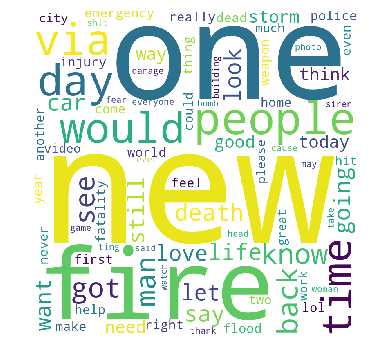

In [14]:
# Erstellung einer WordCloud auf Basis "text_clean_lem"

!pip install wordcloud
from wordcloud import WordCloud

wc = WordCloud(width=800, height=800, 
               background_color="white", 
               stopwords=[''],
               min_font_size=14
               )
wordcloud = wc.generate(" ".join(df_fire["text_clean_lem"]))

plt.figure(figsize=(6, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [15]:
special_word = df_fire['text_clean_lem'].str.contains('got').sum()
print(special_word)

141


In [16]:
df_fire.loc[df_fire['text_clean_lem'].str.contains('got'),'text_clean_lem']


4       got sent photo ruby alaska smoke wildfire pour...
67      kid cuz got bicycle accident split testicle im...
99      car even week got fucking car accident mf fuck...
241     fun filled happy hour simmons bar camden hands...
313     gonna beat armageddon hsu hao got flawless fir...
352     seeing army whitewalkers first thing slightly ...
441                               kill got court day earl
539                             got video rapper got song
562         check item got phantasmal cummerbund warcraft
615     darrellissa great iran deal cover bioterrorism...
618     creation climate change bioterrorism mass auto...
659                                   got bar even rapper
684              bowl got thinking damn blazing damn long
760                codythompson blew motor went flame got
789     todd calfee mattburgener wanted see info bligh...
872     man somebody gotta stop sbee dude fuckin funny...
893                   gotta try let many bloody thing smh
922           

In [17]:
special_word1 = df_fire['text_clean_lem'].str.contains('new').sum()
print(special_word1)

507


In [18]:
df_fire.loc[df_fire['text_clean_lem'].str.contains('new'),'text_clean_lem']


33      africanbaze breaking news nigeria flag set abl...
36      phdsquares mufc built much hype around new acq...
63      navista steve fire something else california t...
76                               accident knew gon happen
136     expert france begin examining airplane debris ...
175     leading emergency service bos welcome new ambu...
179       new nanotech device able tar destroy blood clot
182     news twelve feared killed pakistani air ambula...
203     twelve feared killed pakistani air ambulance h...
236     tomcatarts annihilated legion survivor imperfe...
288     zonewolf youtube video minecraft night lucky b...
314     enews ben affleck know wife kid girl help love...
384     another fake hate crime lesbian burn house els...
385     los angeles time arson suspect linked fire cau...
395     kisii police kisii hunt student failed arson p...
430     arsonist blamed blaze plastic recycling busine...
437     arsonist set nyc arian restaurant fire police ...
451     scare 

# Preprocessing with Spacy 

In [19]:
nlp = spacy.load('en_core_web_sm')
df_fire['text_clean_lem_spac'] = df_fire['text'].apply(lambda text: " ".join([token.lemma_ for token in nlp(text)])).apply(lambda text: " ".join([token.lemma_ for token in nlp(text)]))

In [20]:
df_fire['text_clean_lem_spac'].shape

(6848,)

In [21]:
type(df_fire['text_clean_lem_spac'])

pandas.core.series.Series

In [22]:
#Text preprocessing with Spacy 

nlp = spacy.load('en_core_web_sm')
text1 = str(df_fire['text_clean_lem_spac'])
doc = nlp(text1)
type(doc)

spacy.tokens.doc.Doc

In [23]:
#Text preprocessing with Spacy 

nlp = spacy.load('en_core_web_sm')





In [24]:
# Spacy token

df = pd.DataFrame()

for i, token in enumerate(doc):
    df.loc[i, 'text'] = token.text
    df.loc[i, 'pos'] = token.pos_
    df.loc[i, 'tag'] = token.tag_
df.head(5)

text    pos   tag
0       0    NUM    CD
1          SPACE   _SP
2  -PRON-  PUNCT  HYPH
3    deed   NOUN    NN
4      be    AUX    VB

In [25]:
# Zergliederung des Textes in einzelne Wörter

df = pd.DataFrame()
for i,token in enumerate(doc):
    df.loc[i,'text'] = token.text
    
print(df.head(15))    

                text
0                  0
1                   
2             -PRON-
3               deed
4                 be
5                the
6             reason
7                 of
8               this
9                  #
10        earthquake
11               ...
12                \n
13                 1
14                  


In [26]:
# Klassifizierung der Token I

for word in doc[:1000]:
    print(f'{word.text:{15}} {word.pos_:{10}} {word.tag_:{10}} {spacy.explain(word.tag_)}')

0               NUM        CD         cardinal number
                SPACE      _SP        None
-PRON-          PUNCT      HYPH       punctuation mark, hyphen
deed            NOUN       NN         noun, singular or mass
be              AUX        VB         verb, base form
the             DET        DT         determiner
reason          NOUN       NN         noun, singular or mass
of              ADP        IN         conjunction, subordinating or preposition
this            DET        DT         determiner
#               SYM        $          symbol, currency
earthquake      NOUN       NN         noun, singular or mass
...             PUNCT      :          punctuation mark, colon or ellipsis

               SPACE      _SP        None
1               NUM        CD         cardinal number
                 SPACE      _SP        None
forest          NOUN       NN         noun, singular or mass
fire            NOUN       NN         noun, singular or mass
near            SCONJ      IN    

In [27]:
# Visisualization of named entities

spacy.displacy.render(doc, style='ent',jupyter=True)

In [28]:
# Visisualization of named entities

spacy.displacy.render(doc, style='dep',jupyter=True,options = {'compact':60})

In [29]:
word_freq = Counter([word.pos_ for word in doc])
common_words = word_freq.most_common(15)
print (common_words)

[('SPACE', 121), ('NOUN', 108), ('PUNCT', 102), ('PROPN', 84), ('NUM', 76), ('ADP', 31), ('VERB', 31), ('DET', 30), ('AUX', 29), ('ADV', 22), ('ADJ', 20), ('SYM', 14), ('CCONJ', 8), ('SCONJ', 5), ('PART', 5)]


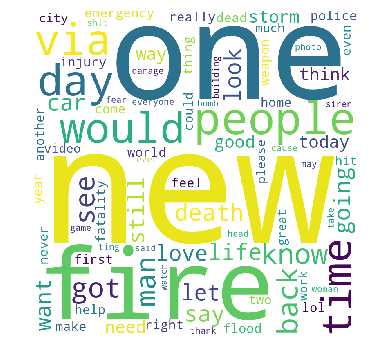

In [30]:
# Erstellung einer WordCloud auf Basis "text_clean_lem_spac"

!pip install wordcloud
from wordcloud import WordCloud

wc = WordCloud(width=800, height=800, 
               background_color="white", 
               stopwords=[''],
               min_font_size=14
               )
wordcloud_spacy = wc.generate(" ".join(df_fire["text_clean_lem_spac"]))

plt.figure(figsize=(6, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Logistic Regression
    - Lemmatizer, Stopwords

In [31]:
# Train Test Split mit der bereinigten Spalte
X=df_fire['text_clean_lem']
y=df_fire['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
display(X_train.shape) 
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(5478,)

(1370,)

(5478,)

(1370,)

In [32]:
# logistic regression

pipe = make_pipeline(CountVectorizer(), LogisticRegression())
pipe.fit(X_train, y_train)



/home/norbert/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
  ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [33]:
# prediction auf basis der x_Testdaten
prediction  = pipe.predict(X_test)
print(classification_report(y_test, prediction)) 


              precision    recall  f1-score   support

           0       0.80      0.89      0.84       814
           1       0.81      0.68      0.74       556

   micro avg       0.80      0.80      0.80      1370
   macro avg       0.80      0.78      0.79      1370
weighted avg       0.80      0.80      0.80      1370



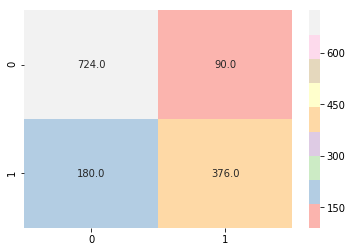

In [34]:
# Heatmap
sns.heatmap(confusion_matrix(y_test, prediction), cmap = 'Pastel1', annot=True, fmt=".1f");

In [35]:
nlp = spacy.load('en_core_web_sm')
X1=df_fire['text_clean_lem_spac']
y1=df_fire['target']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
display(X1_train.shape) 
display(X1_test.shape)
display(y1_train.shape)
display(y1_test.shape)

(5478,)

(1370,)

(5478,)

(1370,)

# Logistic Regression
- Spacy

In [36]:
# logistic regression with spacy corrected text

pipe = make_pipeline(CountVectorizer(), LogisticRegression())
pipe.fit(X1_train, y1_train)



Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
  ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [37]:
# prediction auf basis der X1 Spacy_Testdaten
prediction_spacy  = pipe.predict(X1_test)
print(classification_report(y1_test, prediction_spacy)) 


              precision    recall  f1-score   support

           0       0.80      0.89      0.84       814
           1       0.80      0.68      0.73       556

   micro avg       0.80      0.80      0.80      1370
   macro avg       0.80      0.78      0.79      1370
weighted avg       0.80      0.80      0.80      1370



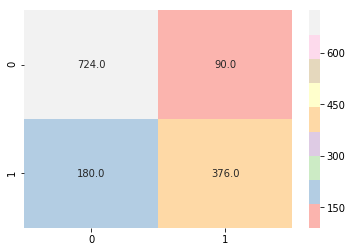

In [38]:
# Heatmap
sns.heatmap(confusion_matrix(y1_test, prediction), cmap = 'Pastel1', annot=True, fmt=".1f");

In [39]:
df_fire.to_csv('/home/norbert/AIDA/twitter-disaster/raw/twitter_disaster_preprocessing.csv',header=False)

In [40]:
df_fire.shape

(6848, 9)

In [42]:
from sklearn.metrics import f1_score
f1_score(y_test, prediction_spacy)

0.7348927875243665

In [43]:
f1_score(y1_test, prediction)

0.735812133072407

In [44]:
from sklearn.model_selection import cross_val_score
cross_val_score(pipe, X1_train, y1_train, cv=5, scoring='f1').mean()

/home/norbert/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7219650163771734

In [45]:
from sklearn.model_selection import cross_val_score
cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1').mean()

/home/norbert/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.721484978269002

In [ ]:
_